# Estimating QDEL Revenue based on COVID-19 Cases
Disclaimer: None of the following is financial advice. It is soley for education and entertainment purposes. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
plt.style.use('seaborn')
import seaborn as sns
from scipy import stats
import math 

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



In [2]:
# COVID-19 information from Our World in Data
path = r"https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
covid = pd.read_csv(path)
filt = covid['iso_code'] == 'USA'
covid = covid[filt]
display(covid)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
147339,USA,North America,United States,2020-01-22,1.0,NaN,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
147340,USA,North America,United States,2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
147341,USA,North America,United States,2020-01-24,2.0,1.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
147342,USA,North America,United States,2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
147343,USA,North America,United States,2020-01-26,5.0,3.0,NaN,NaN,NaN,NaN,...,19.1,24.6,NaN,2.77,78.86,0.926,-8925.0,-3.59,-2.63,-26.808639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148063,USA,North America,United States,2022-01-15,65497024.0,533085.0,813879.286,850383.0,803.0,1719.143,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
148064,USA,North America,United States,2022-01-16,65908656.0,411632.0,805121.714,850931.0,548.0,1737.571,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
148065,USA,North America,United States,2022-01-17,66615031.0,706375.0,710428.714,852062.0,1131.0,1633.571,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
148066,USA,North America,United States,2022-01-18,67672872.0,1057841.0,751799.571,853958.0,1896.0,1576.286,...,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN


In [3]:
path = r"https://raw.githubusercontent.com/andrew-hattling/Public-Data-Projects/main/qdel_info.csv"
qdel_df = pd.read_csv(path)
column_names = {'Unnamed: 0':'Year',
                'Cost of Goods and Services Sold': 'COGS',
                'Revenue from Contract with Customer, Including Assessed Tax':'Revenue',
                'Basic and diluted loss per share':'basic_eps', 
                'Diluted net earnings (loss) per share':'diluted_eps'}
qdel = yf.Ticker('qdel')
qdel_df = qdel_df.rename(columns = column_names)
qdel_df.index = pd.to_datetime(qdel_df['Year'])
qdel_df = qdel_df.replace('[\$,)]','', regex=True )\
                         .replace( '[(]','-', regex=True)\
                         .replace( '', 'NaN', regex=True)
qdel_df.index = qdel_df['Year']
qdel_df = qdel_df.drop('Year', axis = 1)
qdel_df = qdel_df.astype(float)
display(qdel_df.head())

,Revenue,COGS,Gross profit,Operating income,Net income,basic_eps,diluted_eps,Gross margin,Operating margin,Profit margin
Year,,,,,,,,,,
Sep. 30 2021,509736.0,136328.0,373408.0,281841.0,215752.0,5.17,5.08,0.732552,0.552916,0.423262
Jun. 30 2021,176610.0,70424.0,106186.0,23306.0,19073.0,0.46,0.45,0.601246,0.131963,0.107995
Mar. 31 2021,375338.0,73379.0,301959.0,224189.0,178084.0,4.19,4.09,0.804499,0.597299,0.474463
Dec. 31 2020,809203.0,107709.0,701494.0,617076.0,470130.0,11.14,10.78,0.866895,0.762573,0.580979
Sep. 30 2020,476058.0,92439.0,383619.0,307959.0,232268.0,5.52,5.33,0.805824,0.646894,0.487899


In [4]:
# aggregate covid data by quarter
data = covid
data.index = pd.to_datetime(data['date'])
data = data.resample('Q').sum()
display(data)


,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,1.121898e+06,192078.0,1.270681e+05,26043.0,5359.0,3097.715,3.369921e+03,576.958,381.685,78.225,...,1337.0,1722.0,0.0,193.90,5520.20,64.820,-115948.4,-25.06,2.51,-348.282217
2020-06-30,1.304092e+08,2450437.0,2.384938e+06,7437169.0,122006.0,122871.426,3.917191e+05,7360.543,7163.802,22339.536,...,1738.1,2238.6,0.0,252.07,7176.26,84.266,1238695.0,100.98,272.47,3720.753720
2020-09-30,4.770104e+08,4591944.0,4.603209e+06,15455651.0,79515.0,78784.712,1.432829e+06,13793.133,13826.981,46425.205,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,2748333.0,146.90,226.49,8255.357641
2020-12-31,1.121072e+09,12928686.0,1.240527e+07,23954635.0,144874.0,137784.282,3.367440e+06,38834.789,37262.561,71954.187,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,4366609.8,169.32,317.77,13116.287429
2021-03-31,2.427812e+09,10368138.0,1.082234e+07,42637906.0,199703.0,206348.432,7.292586e+06,31143.491,32507.794,128074.423,...,1719.0,2214.0,0.0,249.30,7097.40,83.340,7349879.4,220.05,262.84,22077.340361
2021-06-30,2.976145e+09,3212657.0,3.366219e+06,53073048.0,52794.0,54635.710,8.939651e+06,9650.081,10111.345,159419.177,...,1738.1,2238.6,0.0,252.07,7176.26,84.266,8142594.0,199.20,69.64,24458.471953
2021-09-30,3.459975e+09,9757730.0,9.454103e+06,58304811.0,95329.0,89072.999,1.039297e+07,29309.972,28397.939,175134.188,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,9162052.6,190.81,284.53,27520.690157
2021-12-31,4.387879e+09,11250308.0,1.013861e+07,70453874.0,127338.0,129889.147,1.318018e+07,33793.326,30454.032,211627.168,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,8552454.6,157.75,164.41,25689.598543
2022-03-31,1.170046e+09,13911318.0,1.290919e+07,15990065.0,30850.0,29223.429,3.514549e+06,41786.388,38776.233,48030.461,...,362.9,467.4,0.0,52.63,1498.34,17.594,0.0,0.00,0.00,0.000000


In [5]:
# Combile Quidel financial information and Covid Data
qdel_covid = pd.merge(qdel_df,data,left_index=True, right_index = True)
display(qdel_covid)

,Revenue,COGS,Gross profit,Operating income,Net income,basic_eps,diluted_eps,Gross margin,Operating margin,Profit margin,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
2020-03-31,174653.0,59662.0,114991.0,51628.0,40237.0,0.96,0.93,0.658397,0.295603,0.230383,...,1337.0,1722.0,0.0,193.90,5520.20,64.820,-115948.4,-25.06,2.51,-348.282217
2020-06-30,201754.0,53003.0,148751.0,83663.0,67652.0,1.61,1.55,0.737289,0.414678,0.335319,...,1738.1,2238.6,0.0,252.07,7176.26,84.266,1238695.0,100.98,272.47,3720.753720
2020-09-30,476058.0,92439.0,383619.0,307959.0,232268.0,5.52,5.33,0.805824,0.646894,0.487899,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,2748333.0,146.90,226.49,8255.357641
2020-12-31,809203.0,107709.0,701494.0,617076.0,470130.0,11.14,10.78,0.866895,0.762573,0.580979,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,4366609.8,169.32,317.77,13116.287429
2021-03-31,375338.0,73379.0,301959.0,224189.0,178084.0,4.19,4.09,0.804499,0.597299,0.474463,...,1719.0,2214.0,0.0,249.30,7097.40,83.340,7349879.4,220.05,262.84,22077.340361
2021-06-30,176610.0,70424.0,106186.0,23306.0,19073.0,0.46,0.45,0.601246,0.131963,0.107995,...,1738.1,2238.6,0.0,252.07,7176.26,84.266,8142594.0,199.20,69.64,24458.471953
2021-09-30,509736.0,136328.0,373408.0,281841.0,215752.0,5.17,5.08,0.732552,0.552916,0.423262,...,1757.2,2263.2,0.0,254.84,7255.12,85.192,9162052.6,190.81,284.53,27520.690157


<function matplotlib.pyplot.show(*args, **kw)>

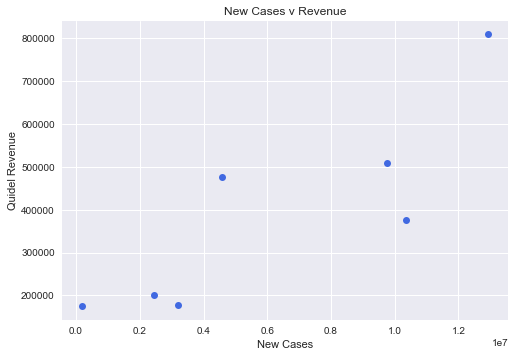

In [6]:

x = qdel_covid[['new_cases']]
y = qdel_covid[['Revenue']]
# create a scatterplot 
plt.plot(x, y, 'o', color = 'royalblue', label = 'Revenue')
# make sure it's formatted
plt.title("New Cases v Revenue")
plt.xlabel("New Cases")
plt.ylabel("Quidel Revenue")
plt.show

In [7]:
# split the data 

#build the model 
x2 = sm.add_constant(x)
model = sm.OLS(y,x2)
est = model.fit()
est.conf_int()

# slow way
regression_model = LinearRegression()
regression_model.fit(x,y)
# let's grab the coefficient of our model and the intercept.
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("The Coefficient for our model is {:.2}".format(coefficient))
print("The intercept for our model is {:.4}".format(intercept))

The Coefficient for our model is 0.042
The intercept for our model is 1.311e+05


In [8]:
y_predict = regression_model.predict(x)
print("For every new covid case, Quidel's Revenues rise by ${:.2f}".format((coefficient * 1000)) + ' on average, all else equal.')
print("Without any COVID-19 cases, Quidel's revenues are estimated to be ${:.2f}".format((intercept * 1000)) + ' per quarter, on average, all else equal.')

For every new covid case, Quidel's Revenues rise by $41.50 on average, all else equal.
Without any COVID-19 cases, Quidel's revenues are estimated to be $131140443.57 per quarter, on average, all else equal.


In [9]:
model_mse = mean_squared_error(y,y_predict)
model_mae = mean_absolute_error(y,y_predict)
model_rmse = math.sqrt(model_mse)
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 1.27e+10
MAE 9.47e+04
RMSE 1.13e+05


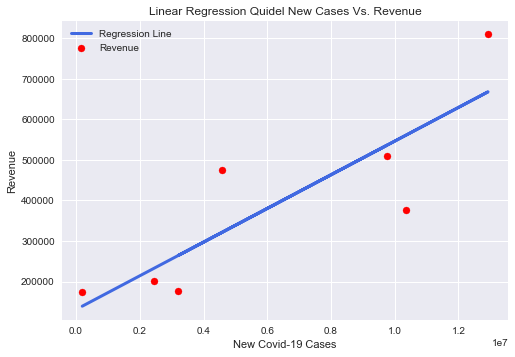

Revenue coefficient:0.042
Mean squared error: 1.273e+10
Root Mean squared error: 1.128e+05
R2 score: 0.73


In [10]:
# Plot outputs
plt.scatter(x, y,  color='red', label = 'Revenue')
plt.plot(x, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression Quidel New Cases Vs. Revenue")
plt.xlabel("New Covid-19 Cases")
plt.ylabel("Revenue")
plt.legend()
plt.show()

# The coefficients
print('Revenue coefficient:' + '\033[1m' + '{:.2}''\033[0m'.format(regression_model.coef_[0][0]))

# The mean squared error
print('Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(model_mse))

# The mean squared error
print('Root Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(math.sqrt(model_mse)))

# Explained variance score: 1 is perfect prediction
print('R2 score: '+ '\033[1m' + '{:.2}''\033[0m'.format(r2_score(y,y_predict)))

In [11]:
d = datetime.date(2021, 12, 31)
cases = data['new_cases'][d]
revenue_predict = (regression_model.predict([[cases]]))

print('Forecasted revenue for Q4 2021 is ${:.8}'.format(revenue_predict[0][0]))

Forecasted revenue for Q4 2021 is $598041.05


## Findings
The model predicted that revenue for Q4 2021 would be 598 million. 
The model also predicted that Quidel's revenues are estimated to be 131 million per quarter, on average, all else equal

These findings are in line with Quidel's latest preliminary revenue announcement. 

According to the release, Quidel's revenues this quarter are from 633 to 637 million, 510 million of which are related to Covid-19. 
Non COVID-19 related revenues in Q4 amounted to about 125 million, very close to the estimated 131 million. 

The model performed well, considering it was within 10% of the amount released in the announcement. Additonally, it was closer to the actual figure then analyst estimates, as the Zack's consensus estimate was only 430 million. 

https://ir.quidel.com/news/news-release-details/2022/Quidel-Announces-Preliminary-Revenue-for-Fourth-Quarter-2021/default.aspx

https://www.zacks.com/stock/news/1850349/quidel-corporation-qdel-reports-solid-preliminary-q4-revenues